In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold
from features import get_features, fea_remap
from features import encode_label
from features import encode_mean_k_fold
from features import encode_frequency
from features import encode_lda
from features import encode_pca

from report import report
from report import get_feature_importance
from report import submit_to_kaggle
import operator
from tqdm import tqdm
import seaborn as sns
import pprint as pp
from itertools import combinations

from tools import drop_cols
from tools import print_corr
from tools import compare_corr
from tools import dict_to_sortedlist

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Load pickle

In [2]:
%%time
df_train = pd.read_pickle("input/train_lv01.pickle")
df_test = pd.read_pickle("input/test_lv01.pickle")

train_size = df_train.shape[0]
target_col = 'totals_transactionRevenue'
df_train[target_col].fillna(0.0, inplace=True)
df_train[target_col] = df_train[target_col].astype(float)


# Drop cols nunique < 2
del_cols = ['totals_bounces', 'totals_newVisits', 'visitId']
df_train = drop_cols(df_train, del_cols)
df_test = drop_cols(df_test, del_cols)

CPU times: user 8.02 s, sys: 1.95 s, total: 9.97 s
Wall time: 8.86 s


#### Corr df_train

["0 (('totals_hits', 'totals_pageviews'), 0.9832053703994799)",
 "1 (('date', 'visitStartTime'), 0.880936102208062)",
 "2 (('totals_pageviews', 'totals_transactionRevenue'), 0.1555900303995555)",
 "3 (('totals_hits', 'totals_transactionRevenue'), 0.1543325542147891)",
 "4 (('visitNumber', 'totals_transactionRevenue'), 0.05136636515154837)",
 "5 (('visitNumber', 'totals_pageviews'), 0.04336274534789543)",
 "6 (('visitNumber', 'totals_hits'), 0.04131692476474782)",
 "7 (('date', 'visitNumber'), 0.00753625750325383)",
 "8 (('date', 'totals_transactionRevenue'), 0.003187841368911753)",
 "9 (('visitStartTime', 'totals_transactionRevenue'), 0.0027237409240615683)",
 "10 (('visitNumber', 'visitStartTime'), 0.002068880592499275)",
 "11 (('date', 'totals_pageviews'), -0.012146094635337614)",
 "12 (('date', 'totals_hits'), -0.018394982375128884)",
 "13 (('visitStartTime', 'totals_pageviews'), -0.02225909838263856)",
 "14 (('visitStartTime', 'totals_hits'), -0.027700832340484788)"]


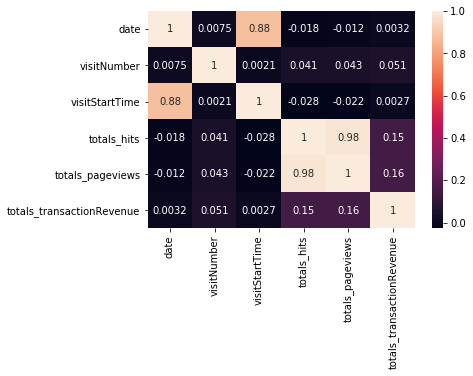

In [3]:
_ = print_corr(df_train.corr())

["0 (('totals_hits', 'totals_pageviews'), 0.9800575656037522)",
 "1 (('date', 'visitStartTime'), 0.8841553602961654)",
 "2 (('visitNumber', 'totals_transactionRevenue'), 0.3088951874376259)",
 "3 (('totals_hits', 'totals_transactionRevenue'), 0.14197348370080032)",
 "4 (('totals_pageviews', 'totals_transactionRevenue'), 0.12864390053779404)",
 "5 (('date', 'visitNumber'), 0.04088787281811942)",
 "6 (('visitNumber', 'visitStartTime'), 0.03130834911244912)",
 "7 (('visitNumber', 'totals_hits'), 0.027940255014209367)",
 "8 (('visitNumber', 'totals_pageviews'), 0.022058257363221638)",
 "9 (('date', 'totals_transactionRevenue'), 0.008099001691115252)",
 "10 (('visitStartTime', 'totals_transactionRevenue'), -0.003446551675520727)",
 "11 (('date', 'totals_pageviews'), -0.13483885435490942)",
 "12 (('date', 'totals_hits'), -0.13667552803199792)",
 "13 (('visitStartTime', 'totals_hits'), -0.16044639545289957)",
 "14 (('visitStartTime', 'totals_pageviews'), -0.1608370293017557)"]


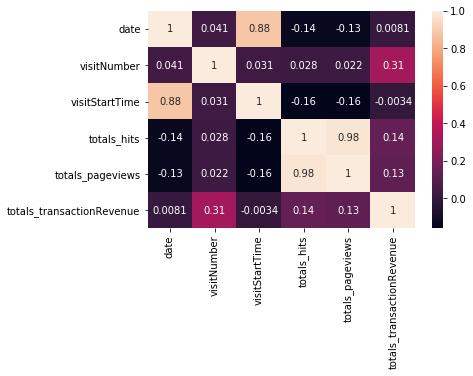

In [4]:
_ = print_corr(df_train[df_train[target_col] > 0].corr())

["0 (('date', 'visitStartTime'), 0.8808927238628838)",
 "1 (('date', 'totals_transactionRevenue'), nan)",
 "2 (('visitNumber', 'totals_transactionRevenue'), nan)",
 "3 (('visitStartTime', 'totals_pageviews'), -0.02376943767396431)",
 "4 (('visitStartTime', 'totals_transactionRevenue'), nan)",
 "5 (('totals_hits', 'totals_pageviews'), 0.980740094385847)",
 "6 (('visitNumber', 'totals_pageviews'), 0.039772247231075065)",
 "7 (('visitNumber', 'totals_hits'), 0.03718826336018407)",
 "8 (('date', 'visitNumber'), 0.006778133806378346)",
 "9 (('visitNumber', 'visitStartTime'), 0.001295115148952827)",
 "10 (('date', 'totals_pageviews'), -0.011927983947012395)",
 "11 (('date', 'totals_hits'), -0.018755569054836496)",
 "12 (('visitStartTime', 'totals_hits'), -0.029549762314588186)",
 "13 (('totals_hits', 'totals_transactionRevenue'), nan)",
 "14 (('totals_pageviews', 'totals_transactionRevenue'), nan)"]


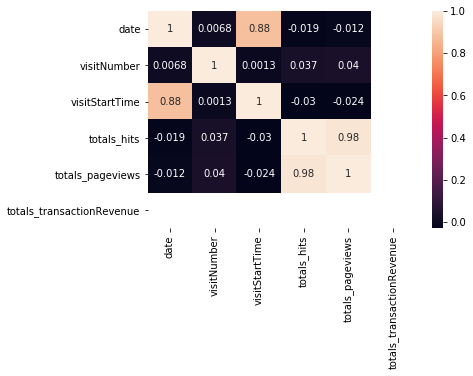

In [5]:
_ = print_corr(df_train[df_train[target_col] == 0].corr())

#### Corr df_test

["0 (('totals_hits', 'totals_pageviews'), 0.9746513723445873)",
 "1 (('date', 'visitStartTime'), 0.8762233183182011)",
 "2 (('visitNumber', 'totals_pageviews'), 0.03194171072593451)",
 "3 (('visitNumber', 'totals_hits'), 0.024853008542083593)",
 "4 (('date', 'visitNumber'), 0.018369869091977284)",
 "5 (('visitNumber', 'visitStartTime'), 0.017582765340019617)",
 "6 (('date', 'totals_hits'), 0.009609805461014713)",
 "7 (('date', 'totals_pageviews'), 0.009378603872817302)",
 "8 (('visitStartTime', 'totals_hits'), 0.008909053761453808)",
 "9 (('visitStartTime', 'totals_pageviews'), 0.008262644484900883)"]


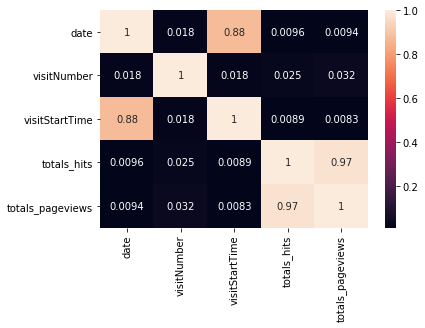

In [6]:
_ = print_corr(df_test.corr())

### Feature Engineering

In [7]:
%%time
df_train = fea_remap(df_train)
df_test = fea_remap(df_test)

CPU times: user 4.03 s, sys: 135 ms, total: 4.16 s
Wall time: 4.17 s


In [8]:
%%time
df_train, fea_cols = get_features(df_train)
df_test, fea_cols = get_features(df_test)
df_train[target_col] = np.log1p(df_train[target_col])

'fea_date_time'  17803.77 ms
'fea_format'  120.64 ms
'fea_device'  2434.63 ms
'fea_totals'  2102.00 ms
'fea_geo_network'  440.10 ms
'fea_traffic_source'  2709.50 ms
'fea_shift'  5321.56 ms
'fea_date_time'  14496.56 ms
'fea_format'  83.21 ms
'fea_device'  2139.24 ms
'fea_totals'  1800.54 ms
'fea_geo_network'  375.03 ms
'fea_traffic_source'  2352.35 ms
'fea_shift'  4862.53 ms
CPU times: user 1min 22s, sys: 10.4 s, total: 1min 32s
Wall time: 57.1 s


In [9]:
fea_cols

['source_country',
 'mean_hits_per_hour',
 'month_unique_user_count',
 'user_hour_min',
 'medium_hits_mean',
 'sum_hits_per_day',
 'campaign_medium',
 'sum_hits_per_network_domain',
 'user_hour_mean',
 'browser_category',
 'month',
 'weekday_unique_user_count',
 'user_hour_max',
 'totals_pageviews_b1',
 'sum_hits_per_hour',
 'visitStartTime_b2_diff',
 'medium_hits_max',
 'max_hits_per_day',
 'browser_operatingSystem',
 'day',
 'max_hits_per_hour',
 'weekday',
 'medium_hits_sum',
 'hour_unique_user_count',
 'hour',
 'var_hits_per_day',
 'totals_hits_b1',
 'mean_pageviews_per_network_domain',
 'mean_hour_per_browser_operatingSystem',
 'medium_hits_min',
 'browser_os',
 'visitStartTime_b1_diff']

#### corr df_train and df_test

["0 (('totals_hits_b1', 'totals_pageviews_b1'), 0.9973186406685033)",
 "1 (('totals_hits', 'totals_pageviews'), 0.9913443377932172)",
 "2 (('hour_unique_user_count', 'sum_hits_per_hour'), 0.956254363002254)",
 "3 (('hour', 'user_hour_mean'), 0.9156129898948033)",
 "4 (('user_hour_mean', 'user_hour_max'), 0.901766949347989)",
 "5 (('date', 'visitStartTime'), 0.880936102208062)",
 "6 (('user_hour_mean', 'user_hour_min'), 0.8688861698568336)",
 "7 (('hour', 'user_hour_max'), 0.8256695326804281)",
 "8 (('visitStartTime_b1_diff', 'totals_pageviews_b1'), 0.8133526668381402)",
 "9 (('visitStartTime_b1_diff', 'totals_hits_b1'), 0.8014309503018728)",
 "10 (('hour', 'user_hour_min'), 0.7955634638610078)",
 "11 (('visitNumber', 'visitStartTime_b2_diff'), 0.7541263673780185)",
 "12 (('hour', 'hour_unique_user_count'), 0.7215833116772377)",
 "13 (('hour', 'sum_hits_per_hour'), 0.7036260321877862)",
 "14 (('month', 'month_unique_user_count'), 0.7026930483006902)",
 "15 (('visitNumber', 'visitStartTi

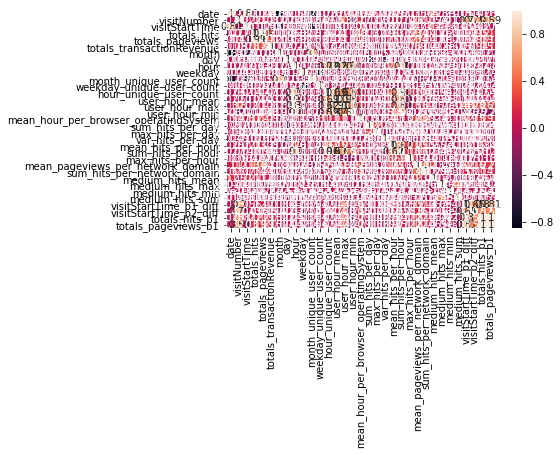

In [10]:
_ = print_corr(df_train.corr())

["0 (('totals_hits_b1', 'totals_pageviews_b1'), 0.9964299533095723)",
 "1 (('totals_hits', 'totals_pageviews'), 0.9878559228487707)",
 "2 (('hour_unique_user_count', 'sum_hits_per_hour'), 0.9765762367595666)",
 "3 (('hour', 'user_hour_mean'), 0.9075730270779645)",
 "4 (('user_hour_mean', 'user_hour_max'), 0.8914223179752869)",
 "5 (('date', 'visitStartTime'), 0.8762233183182011)",
 "6 (('user_hour_mean', 'user_hour_min'), 0.8649029707520625)",
 "7 (('visitStartTime_b1_diff', 'totals_pageviews_b1'), 0.81130794153178)",
 "8 (('hour', 'user_hour_max'), 0.809030851529575)",
 "9 (('visitStartTime_b1_diff', 'totals_hits_b1'), 0.7965137993059719)",
 "10 (('hour', 'user_hour_min'), 0.7849626072942254)",
 "11 (('medium_hits_mean', 'medium_hits_max'), 0.7747514310395078)",
 "12 (('visitNumber', 'visitStartTime_b2_diff'), 0.7578660509708949)",
 "13 (('medium_hits_mean', 'medium_hits_sum'), 0.7354684113713564)",
 "14 (('visitNumber', 'visitStartTime_b1_diff'), 0.7027667030224408)",
 "15 (('mean_hi

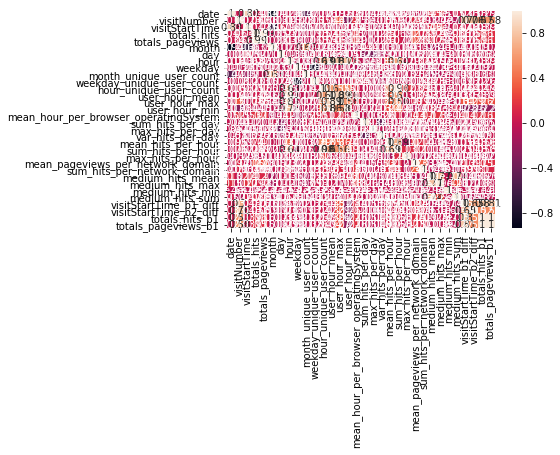

In [11]:
_ = print_corr(df_test.corr())

#### ttest between df_train and df_test

In [12]:
# from scipy.stats import ttest_ind
# c = 'browser_category'
# print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

# for c in fea_cols:
#     print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

### Encodings

In [13]:
not_used_cols = [
    "date",
    "fullVisitorId",
    "sessionId",
    "visitId",
    'trafficSource_campaignCode',
    target_col,
    #     "visitNumber",
    #     "visitStartTime",
    #     'trafficSource_referralPath',
]

categorical_feature = df_train.select_dtypes(include='object').columns
categorical_feature = [
    c for c in categorical_feature if c not in not_used_cols
]
df_train[categorical_feature].fillna('NA_NULL', inplace=True)
df_test[categorical_feature].fillna('NA_NULL', inplace=True)

len(categorical_feature)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


29

#### Label Encoding

In [14]:
df_train, df_test = encode_label(df_train, df_test, categorical_feature)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'browser_category', 'browser_operatingSystem', 'source_country', 'browser_os', 'campaign_medium']


100%|██████████| 29/29 [00:46<00:00,  1.08s/it]


'encode_label'  50911.56 ms


#### Freq Encoding

In [15]:
df_train, df_test = encode_frequency(df_train, df_test, categorical_feature)

100%|██████████| 29/29 [00:31<00:00,  1.14s/it]

(903653, 93) (804684, 92)
'encode_frequency'  32088.32 ms


#### Mean Encoding

In [16]:
df_train, df_test = encode_mean_k_fold(df_train, df_test, categorical_feature, target_col)

100%|██████████| 29/29 [01:39<00:00,  3.79s/it]

(903653, 122) (804684, 121)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem',
       ...
       'mean_k_fold_trafficSource_isTrueDirect',
       'mean_k_fold_trafficSource_keyword', 'mean_k_fold_trafficSource_medium',
       'mean_k_fold_trafficSource_referralPath',
       'mean_k_fold_trafficSource_source', 'mean_k_fold_browser_category',
       'mean_k_fold_browser_operatingSystem', 'mean_k_fold_source_country',
       'mean_k_fold_browser_os', 'mean_k_fold_campaign_medium'],
      dtype='object', length=122)
'encode_mean_k_fold'  99737.53 ms


#### LDA (target_col) : 망함

In [17]:
# y_categorized = np.digitize(df_train[target_col], bins=np.arange(2,24,2))
# clf = LinearDiscriminantAnalysis(n_components=10)
# clf.fit(df_train[categorical_feature], y_categorized)

In [18]:
# df_train_lda = pd.DataFrame(clf.transform(df_train[categorical_feature]))
# df_test_lda = pd.DataFrame(clf.transform(df_test[categorical_feature]))

# col_map={i:'lda_{}'.format(i) for i in range(10)}
# df_train_lda.rename(columns=col_map, inplace=True)
# df_test.rename(columns=col_map, inplace=True)

# df_train = pd.concat([df_train, df_train_lda], axis=1)
# df_test = pd.concat([df_test, df_test_lda], axis=1)                

#### LDA (totals_hits) : good

In [19]:
# y_col = 'totals_hits'
# merged_y = pd.concat([df_train[y_col], df_test[y_col]])
# merged_y.hist()
# y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [20]:
# df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

#### LDA (totals_pageviews) : better

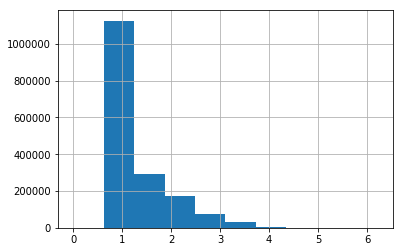

In [21]:
y_col = 'totals_pageviews'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [22]:
df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, n_components=10, fea_name=y_col)

lda_totals_pageviews_0to9


/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(903653, 127) (804684, 126)
'encode_lda'  8396.28 ms


#### LDA (hits / pageviews) : 망함

In [23]:
# y_col = 'hits_pageviews_rate'
# merged_y = pd.concat([
#     df_train['totals_hits'] / df_train['totals_pageviews'],
#     df_test['totals_hits'] / df_test['totals_pageviews']
# ])
# merged_y[np.isinf(merged_y)] = 0
# merged_y = merged_y * 10
# merged_y.hist()

In [24]:
# bins = np.arange(10,25,1)
# bins = np.insert(bins, 0, 0)
# y_categorized = np.digitize(merged_y, bins=bins)
# np.unique(y_categorized, return_counts=True)

In [25]:
# df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

#### PCA (totals_hits or totals_pageviews(망)) : 

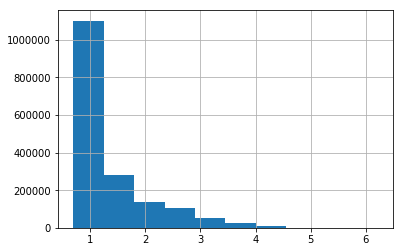

In [26]:
y_col = 'totals_hits'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [27]:
df_train, df_test = encode_pca(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

pca_totals_hits_0to9
(903653, 137) (804684, 136)
'encode_pca'  11922.98 ms


### Split X and y, Remove not_used_cols

In [28]:
# del_cols = [c for c in df_train.columns if 'lda_totals_pageviews' in c]
# df_train.drop(del_cols, axis=1, inplace=True)
# df_test.drop(del_cols, axis=1, inplace=True)

In [29]:
df_train_y = df_train[target_col].astype(float)

df_train_idx = df_train[['fullVisitorId', target_col]]
df_train_X = drop_cols(df_train.copy(), not_used_cols)

df_test_idx = df_test[['fullVisitorId']]
df_test_X = drop_cols(df_test.copy(), not_used_cols)

In [30]:
# del_cols = [c for c in df_train_X.columns if 'pca_totals_pageviews' in c]
# df_train_X.drop(del_cols, axis=1, inplace=True)
# df_test_X.drop(del_cols, axis=1, inplace=True)

### Training

In [31]:
def modeling(X_train, X_valid, y_train, y_valid, params, model_tag):
    print('X_train:', X_train.shape, 'X_valid:', X_valid.shape, 'Rate:',
          X_valid.shape[0] / X_train.shape[0])
    if X_valid.shape[0] / X_train.shape[0] > 1.0:
        print('No Execution')
        return

    train = lgb.Dataset(
        X_train.values,
        label=y_train.values,
        feature_name=feature_name,
#                         categorical_feature=categorical_feature
    )

    valid = lgb.Dataset(
        X_valid.values,
        label=y_valid.values,
        feature_name=feature_name,
#                         categorical_feature=categorical_feature
    )

    evals_result = {}
    train_params = {
        'params': params,
        'train_set': train,
        'valid_sets': [train, valid],
        'valid_names': ['train', 'valid'],
        'early_stopping_rounds': 300,  #50
        'num_boost_round': 10000,  #500
        'verbose_eval': 25,
        'feval': None,
        'evals_result': evals_result,
        #     'categorical_feature': 'auto',
    }

    model = lgb.train(**train_params)

    global prediction_train, prediction
    print('predict train set')
    pred_train = model.predict(
        df_train_X.values, num_iteration=model.best_iteration)
    prediction_train += pred_train
    df_fold_train = df_train_idx.copy()
    df_fold_train[model_tag] = pred_train

    print('predict test set')
    pred = model.predict(df_test_X.values, num_iteration=model.best_iteration)
    prediction += pred
    df_fold_test = df_test_idx.copy()
    df_fold_test[model_tag] = pred

    # report
    global submit_file_path
    submit_file_path = ''
    msg = [model_tag, str(df_train_X.columns.values), str(train_params)]
    submit_file_path = report(df_fold_train, df_fold_test, pred_train, pred,
                              msg, model)
    print(submit_file_path)

    return model

#### Train 531

In [32]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])
submit_file_path = ''

#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "max_depth": 8,
#         "min_child_samples": 20,
#         "reg_alpha": 1,
#         "reg_lambda": 1,
#         "num_leaves": 257,
#         "learning_rate": 0.01,
#         "subsample": 0.8,
#         "colsample_bytree": 0.8,
#         "subsample_freq ": 5,
#     }
#     params = {
#     "objective": "regression",
#     "metric": "rmse",
#     "num_leaves": 30,
#     "min_child_samples": 100,
#     "learning_rate": 0.1,
#     "bagging_fraction": 0.7,
#     "feature_fraction": 0.5,
#     "bagging_frequency": 5,
#     "bagging_seed": 2018,
#     "verbosity": -1
# }

# param = {
#     "objective": "regression",
#     "metric": "rmse",
#     "max_depth": 8,
#     "min_child_samples": 21,
#     "reg_alpha": 1,
#     "reg_lambda": 1,
#     "num_leaves": 257,
#     "learning_rate": 0.01,
#     "subsample": 0.82,
#     "colsample_bytree": 0.84,
#     "verbosity": -1
# }

params = {
    "boosting_type": 'gbdt',  #'dart', #gbdt',
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 24,  #15 #20 #24 #30
    "min_child_samples": 100,
    "learning_rate": 0.01,  #0.1
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 1989,
    "verbosity": -1,
    'seed': 1989
}

# model_tag = 20170430
model_tag = 20170531
cond = df_train['date'] <= model_tag
X_train, X_valid = df_train_X[cond], df_train_X[~cond]
y_train, y_valid = df_train_y[cond], df_train_y[~cond]

model = modeling(X_train, X_valid, y_train, y_valid, params, str(model_tag))

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'browser_category', 'browser_operatingSystem', 'mean_hour_per_browser_operatingSystem', 'source_co

[2100]	train's rmse: 1.4888	valid's rmse: 1.67765
[2125]	train's rmse: 1.48778	valid's rmse: 1.67751
[2150]	train's rmse: 1.4867	valid's rmse: 1.67734
[2175]	train's rmse: 1.48582	valid's rmse: 1.67724
[2200]	train's rmse: 1.48478	valid's rmse: 1.67695
[2225]	train's rmse: 1.48384	valid's rmse: 1.67675
[2250]	train's rmse: 1.48274	valid's rmse: 1.67676
[2275]	train's rmse: 1.48163	valid's rmse: 1.67671
[2300]	train's rmse: 1.48053	valid's rmse: 1.67665
[2325]	train's rmse: 1.47946	valid's rmse: 1.6767
[2350]	train's rmse: 1.47835	valid's rmse: 1.67649
[2375]	train's rmse: 1.47742	valid's rmse: 1.67642
[2400]	train's rmse: 1.47645	valid's rmse: 1.6763
[2425]	train's rmse: 1.47526	valid's rmse: 1.676
[2450]	train's rmse: 1.47442	valid's rmse: 1.67593
[2475]	train's rmse: 1.47367	valid's rmse: 1.6759
[2500]	train's rmse: 1.47278	valid's rmse: 1.67589
[2525]	train's rmse: 1.47191	valid's rmse: 1.67581
[2550]	train's rmse: 1.47096	valid's rmse: 1.67576
[2575]	train's rmse: 1.46999	valid's r

raw_train: results/2018-10-01T011025__T1.432_V1.673_R1.169_K/reg_train_2018-10-01T011025.csv
raw_test: results/2018-10-01T011025__T1.432_V1.673_R1.169_K/reg_test_2018-10-01T011025.csv
submit: results/2018-10-01T011025__T1.432_V1.673_R1.169_K/aiden_2018-10-01T011025.csv.tar.gz
cp -f *py* results/2018-10-01T011025__T1.432_V1.673_R1.169_K
    
results/2018-10-01T011025__T1.432_V1.673_R1.169_K/aiden_2018-10-01T011025.csv.tar.gz


#### Train CV

In [33]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])
submit_file_path = ''

params = {
    "boosting_type": 'gbdt',  #'dart', #gbdt',
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 24,  #15 #20 #24 #30
    "min_child_samples": 100,
    "learning_rate": 0.01,  #0.1
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 1989,
    "verbosity": -1,
    'seed': 1989
}

N_SPLITS = 6
folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
y_categorized = np.digitize(df_train_y.values, bins=np.arange(2, 24, 2))

for fold_n, (train_index, test_index) in enumerate(
        folds.split(df_train_X, y_categorized)):
    model_tag = 'StratifiedKFold_{0:02d}'.format(fold_n)
    print('model_tag:', model_tag)

    X_train, X_valid = df_train_X.iloc[train_index], df_train_X.iloc[
        test_index]
    y_train, y_valid = df_train_y.iloc[train_index], df_train_y.iloc[
        test_index]

    model = modeling(X_train, X_valid, y_train, y_valid, params, model_tag)

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'browser_category', 'browser_operatingSystem', 'mean_hour_per_browser_operatingSystem', 'source_co

/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


model_tag: StratifiedKFold_00
X_train: (753042, 133) X_valid: (150611, 133) Rate: 0.2000034526626669
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.91558	valid's rmse: 1.91698
[50]	train's rmse: 1.846	valid's rmse: 1.84896
[75]	train's rmse: 1.79471	valid's rmse: 1.79897
[100]	train's rmse: 1.75709	valid's rmse: 1.76258
[125]	train's rmse: 1.72651	valid's rmse: 1.73345
[150]	train's rmse: 1.70152	valid's rmse: 1.71019
[175]	train's rmse: 1.68304	valid's rmse: 1.69325
[200]	train's rmse: 1.6698	valid's rmse: 1.6814
[225]	train's rmse: 1.6592	valid's rmse: 1.67223
[250]	train's rmse: 1.65157	valid's rmse: 1.66604
[275]	train's rmse: 1.64505	valid's rmse: 1.66096
[300]	train's rmse: 1.63828	valid's rmse: 1.65562
[325]	train's rmse: 1.6323	valid's rmse: 1.65107
[350]	train's rmse: 1.62681	valid's rmse: 1.64705
[375]	train's rmse: 1.62246	valid's rmse: 1.64409
[400]	train's rmse: 1.61821	valid's rmse: 1.64138
[425]	train's rmse: 1.61427	valid's rmse: 1.6

raw_train: results/2018-10-01T011438__T1.463_V1.603_R1.096_K/reg_train_2018-10-01T011438.csv
raw_test: results/2018-10-01T011438__T1.463_V1.603_R1.096_K/reg_test_2018-10-01T011438.csv
submit: results/2018-10-01T011438__T1.463_V1.603_R1.096_K/aiden_2018-10-01T011438.csv.tar.gz
cp -f *py* results/2018-10-01T011438__T1.463_V1.603_R1.096_K
    
results/2018-10-01T011438__T1.463_V1.603_R1.096_K/aiden_2018-10-01T011438.csv.tar.gz
model_tag: StratifiedKFold_01
X_train: (753042, 133) X_valid: (150611, 133) Rate: 0.2000034526626669
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.91579	valid's rmse: 1.91656
[50]	train's rmse: 1.84664	valid's rmse: 1.84673
[75]	train's rmse: 1.7958	valid's rmse: 1.79555
[100]	train's rmse: 1.7584	valid's rmse: 1.75816
[125]	train's rmse: 1.72801	valid's rmse: 1.72793
[150]	train's rmse: 1.70315	valid's rmse: 1.70342
[175]	train's rmse: 1.68494	valid's rmse: 1.68573
[200]	train's rmse: 1.67176	valid's rmse: 1.67344
[225]	train's

[3800]	train's rmse: 1.44208	valid's rmse: 1.58559
[3825]	train's rmse: 1.44118	valid's rmse: 1.58562
[3850]	train's rmse: 1.44041	valid's rmse: 1.58573
[3875]	train's rmse: 1.43963	valid's rmse: 1.58558
[3900]	train's rmse: 1.4389	valid's rmse: 1.58555
[3925]	train's rmse: 1.43801	valid's rmse: 1.5855
[3950]	train's rmse: 1.4373	valid's rmse: 1.58553
[3975]	train's rmse: 1.43649	valid's rmse: 1.58554
[4000]	train's rmse: 1.43575	valid's rmse: 1.58547
[4025]	train's rmse: 1.43505	valid's rmse: 1.58542
[4050]	train's rmse: 1.43433	valid's rmse: 1.58537
[4075]	train's rmse: 1.43347	valid's rmse: 1.58533
[4100]	train's rmse: 1.43259	valid's rmse: 1.58526
[4125]	train's rmse: 1.43194	valid's rmse: 1.58519
[4150]	train's rmse: 1.43122	valid's rmse: 1.58518
[4175]	train's rmse: 1.43057	valid's rmse: 1.5851
[4200]	train's rmse: 1.42984	valid's rmse: 1.58511
[4225]	train's rmse: 1.42894	valid's rmse: 1.5852
[4250]	train's rmse: 1.42816	valid's rmse: 1.58521
[4275]	train's rmse: 1.42743	valid's

raw_train: results/2018-10-01T011957__T1.430_V1.585_R1.108_K/reg_train_2018-10-01T011957.csv
raw_test: results/2018-10-01T011957__T1.430_V1.585_R1.108_K/reg_test_2018-10-01T011957.csv
submit: results/2018-10-01T011957__T1.430_V1.585_R1.108_K/aiden_2018-10-01T011957.csv.tar.gz
cp -f *py* results/2018-10-01T011957__T1.430_V1.585_R1.108_K
    
results/2018-10-01T011957__T1.430_V1.585_R1.108_K/aiden_2018-10-01T011957.csv.tar.gz
model_tag: StratifiedKFold_02
X_train: (753042, 133) X_valid: (150611, 133) Rate: 0.2000034526626669
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.91505	valid's rmse: 1.91747
[50]	train's rmse: 1.84492	valid's rmse: 1.84996
[75]	train's rmse: 1.79343	valid's rmse: 1.80082
[100]	train's rmse: 1.75585	valid's rmse: 1.76572
[125]	train's rmse: 1.72494	valid's rmse: 1.7373
[150]	train's rmse: 1.70005	valid's rmse: 1.71493
[175]	train's rmse: 1.68165	valid's rmse: 1.69883
[200]	train's rmse: 1.66848	valid's rmse: 1.68754
[225]	train'

[3800]	train's rmse: 1.44084	valid's rmse: 1.60107
[3825]	train's rmse: 1.44008	valid's rmse: 1.60106
[3850]	train's rmse: 1.43932	valid's rmse: 1.60102
[3875]	train's rmse: 1.43852	valid's rmse: 1.60094
[3900]	train's rmse: 1.43784	valid's rmse: 1.60091
[3925]	train's rmse: 1.43702	valid's rmse: 1.60083
[3950]	train's rmse: 1.43627	valid's rmse: 1.60083
[3975]	train's rmse: 1.43542	valid's rmse: 1.60078
[4000]	train's rmse: 1.43475	valid's rmse: 1.60075
[4025]	train's rmse: 1.43412	valid's rmse: 1.60065
[4050]	train's rmse: 1.43346	valid's rmse: 1.60059
[4075]	train's rmse: 1.43256	valid's rmse: 1.60053
[4100]	train's rmse: 1.43172	valid's rmse: 1.60051
[4125]	train's rmse: 1.43104	valid's rmse: 1.60048
[4150]	train's rmse: 1.43034	valid's rmse: 1.60048
[4175]	train's rmse: 1.42959	valid's rmse: 1.60045
[4200]	train's rmse: 1.42884	valid's rmse: 1.60042
[4225]	train's rmse: 1.42812	valid's rmse: 1.6004
[4250]	train's rmse: 1.42729	valid's rmse: 1.60029
[4275]	train's rmse: 1.42652	val

raw_train: results/2018-10-01T012719__T1.393_V1.599_R1.148_K/reg_train_2018-10-01T012719.csv
raw_test: results/2018-10-01T012719__T1.393_V1.599_R1.148_K/reg_test_2018-10-01T012719.csv
submit: results/2018-10-01T012719__T1.393_V1.599_R1.148_K/aiden_2018-10-01T012719.csv.tar.gz
cp -f *py* results/2018-10-01T012719__T1.393_V1.599_R1.148_K
    
results/2018-10-01T012719__T1.393_V1.599_R1.148_K/aiden_2018-10-01T012719.csv.tar.gz
model_tag: StratifiedKFold_03
X_train: (753044, 133) X_valid: (150609, 133) Rate: 0.20000026558873055
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.91471	valid's rmse: 1.91849
[50]	train's rmse: 1.84496	valid's rmse: 1.85102
[75]	train's rmse: 1.79363	valid's rmse: 1.80149
[100]	train's rmse: 1.75598	valid's rmse: 1.76543
[125]	train's rmse: 1.72544	valid's rmse: 1.73638
[150]	train's rmse: 1.70055	valid's rmse: 1.71277
[175]	train's rmse: 1.68225	valid's rmse: 1.6957
[200]	train's rmse: 1.66922	valid's rmse: 1.68394
[225]	train

[3800]	train's rmse: 1.44282	valid's rmse: 1.59329
[3825]	train's rmse: 1.44205	valid's rmse: 1.5933
[3850]	train's rmse: 1.44131	valid's rmse: 1.59325
[3875]	train's rmse: 1.44057	valid's rmse: 1.59316
[3900]	train's rmse: 1.43985	valid's rmse: 1.59317
[3925]	train's rmse: 1.43909	valid's rmse: 1.59313
[3950]	train's rmse: 1.4384	valid's rmse: 1.59314
[3975]	train's rmse: 1.4376	valid's rmse: 1.59316
[4000]	train's rmse: 1.43688	valid's rmse: 1.59308
[4025]	train's rmse: 1.43617	valid's rmse: 1.59305
[4050]	train's rmse: 1.43537	valid's rmse: 1.59295
[4075]	train's rmse: 1.43443	valid's rmse: 1.59291
[4100]	train's rmse: 1.43365	valid's rmse: 1.59292
[4125]	train's rmse: 1.43298	valid's rmse: 1.59294
[4150]	train's rmse: 1.43227	valid's rmse: 1.59299
[4175]	train's rmse: 1.43166	valid's rmse: 1.59302
[4200]	train's rmse: 1.43089	valid's rmse: 1.593
[4225]	train's rmse: 1.4301	valid's rmse: 1.59299
[4250]	train's rmse: 1.42935	valid's rmse: 1.59289
[4275]	train's rmse: 1.42866	valid's 

raw_train: results/2018-10-01T013342__T1.413_V1.593_R1.127_K/reg_train_2018-10-01T013342.csv
raw_test: results/2018-10-01T013342__T1.413_V1.593_R1.127_K/reg_test_2018-10-01T013342.csv
submit: results/2018-10-01T013342__T1.413_V1.593_R1.127_K/aiden_2018-10-01T013342.csv.tar.gz
cp -f *py* results/2018-10-01T013342__T1.413_V1.593_R1.127_K
    
results/2018-10-01T013342__T1.413_V1.593_R1.127_K/aiden_2018-10-01T013342.csv.tar.gz
model_tag: StratifiedKFold_04
X_train: (753047, 133) X_valid: (150606, 133) Rate: 0.1999954850095678
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.91533	valid's rmse: 1.91628
[50]	train's rmse: 1.84522	valid's rmse: 1.84931
[75]	train's rmse: 1.79344	valid's rmse: 1.80067
[100]	train's rmse: 1.75551	valid's rmse: 1.76574
[125]	train's rmse: 1.72457	valid's rmse: 1.73811
[150]	train's rmse: 1.69938	valid's rmse: 1.71625
[175]	train's rmse: 1.68086	valid's rmse: 1.70087
[200]	train's rmse: 1.66742	valid's rmse: 1.68997
[225]	train

[3800]	train's rmse: 1.4385	valid's rmse: 1.61286
[3825]	train's rmse: 1.43774	valid's rmse: 1.61293
[3850]	train's rmse: 1.43707	valid's rmse: 1.61287
[3875]	train's rmse: 1.43647	valid's rmse: 1.61286
[3900]	train's rmse: 1.43586	valid's rmse: 1.61282
[3925]	train's rmse: 1.43509	valid's rmse: 1.61273
[3950]	train's rmse: 1.43442	valid's rmse: 1.61274
[3975]	train's rmse: 1.43377	valid's rmse: 1.61273
[4000]	train's rmse: 1.43312	valid's rmse: 1.61278
[4025]	train's rmse: 1.43245	valid's rmse: 1.61291
[4050]	train's rmse: 1.43173	valid's rmse: 1.61281
[4075]	train's rmse: 1.43088	valid's rmse: 1.61274
[4100]	train's rmse: 1.43011	valid's rmse: 1.61274
[4125]	train's rmse: 1.4295	valid's rmse: 1.61271
[4150]	train's rmse: 1.42883	valid's rmse: 1.61271
[4175]	train's rmse: 1.4282	valid's rmse: 1.61276
[4200]	train's rmse: 1.42766	valid's rmse: 1.61282
[4225]	train's rmse: 1.42698	valid's rmse: 1.61286
[4250]	train's rmse: 1.42625	valid's rmse: 1.61287
[4275]	train's rmse: 1.4255	valid'

raw_train: results/2018-10-01T014125__T1.429_V1.613_R1.128_K/reg_train_2018-10-01T014125.csv
raw_test: results/2018-10-01T014125__T1.429_V1.613_R1.128_K/reg_test_2018-10-01T014125.csv
submit: results/2018-10-01T014125__T1.429_V1.613_R1.128_K/aiden_2018-10-01T014125.csv.tar.gz
cp -f *py* results/2018-10-01T014125__T1.429_V1.613_R1.128_K
    
results/2018-10-01T014125__T1.429_V1.613_R1.128_K/aiden_2018-10-01T014125.csv.tar.gz
model_tag: StratifiedKFold_05
X_train: (753048, 133) X_valid: (150605, 133) Rate: 0.19999389149164462
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.91594	valid's rmse: 1.9156
[50]	train's rmse: 1.84644	valid's rmse: 1.84697
[75]	train's rmse: 1.79534	valid's rmse: 1.79664
[100]	train's rmse: 1.75778	valid's rmse: 1.75955
[125]	train's rmse: 1.72716	valid's rmse: 1.73025
[150]	train's rmse: 1.70226	valid's rmse: 1.70665
[175]	train's rmse: 1.68389	valid's rmse: 1.68967
[200]	train's rmse: 1.67068	valid's rmse: 1.67759
[225]	train

[3800]	train's rmse: 1.44368	valid's rmse: 1.5865
[3825]	train's rmse: 1.44291	valid's rmse: 1.58653
[3850]	train's rmse: 1.44219	valid's rmse: 1.58647
[3875]	train's rmse: 1.44156	valid's rmse: 1.58645
[3900]	train's rmse: 1.44093	valid's rmse: 1.58647
[3925]	train's rmse: 1.44011	valid's rmse: 1.58638
[3950]	train's rmse: 1.43932	valid's rmse: 1.58636
[3975]	train's rmse: 1.43854	valid's rmse: 1.58635
[4000]	train's rmse: 1.43778	valid's rmse: 1.58624
[4025]	train's rmse: 1.43716	valid's rmse: 1.58624
[4050]	train's rmse: 1.43655	valid's rmse: 1.5863
[4075]	train's rmse: 1.43579	valid's rmse: 1.58627
[4100]	train's rmse: 1.43499	valid's rmse: 1.5862
[4125]	train's rmse: 1.43429	valid's rmse: 1.58613
[4150]	train's rmse: 1.43362	valid's rmse: 1.58612
[4175]	train's rmse: 1.43302	valid's rmse: 1.58604
[4200]	train's rmse: 1.43232	valid's rmse: 1.586
[4225]	train's rmse: 1.43158	valid's rmse: 1.58599
[4250]	train's rmse: 1.43077	valid's rmse: 1.58587
[4275]	train's rmse: 1.43002	valid's

raw_train: results/2018-10-01T082524__T1.400_V1.585_R1.132_K/reg_train_2018-10-01T082524.csv
raw_test: results/2018-10-01T082524__T1.400_V1.585_R1.132_K/reg_test_2018-10-01T082524.csv
submit: results/2018-10-01T082524__T1.400_V1.585_R1.132_K/aiden_2018-10-01T082524.csv.tar.gz
cp -f *py* results/2018-10-01T082524__T1.400_V1.585_R1.132_K
    
results/2018-10-01T082524__T1.400_V1.585_R1.132_K/aiden_2018-10-01T082524.csv.tar.gz


#### Report CV results

In [34]:
msg = [
    'cv_{}'.format(N_SPLITS),
    str(feature_name),
]
pred_train = prediction_train / N_SPLITS
pred = prediction / N_SPLITS
submit_file_path = report(df_train_idx.copy(), df_test_idx.copy(), pred_train, pred, msg)
print(submit_file_path)

raw_train: results/2018-10-01T082538__NONE/reg_train_2018-10-01T082538.csv
raw_test: results/2018-10-01T082538__NONE/reg_test_2018-10-01T082538.csv
submit: results/2018-10-01T082538__NONE/aiden_2018-10-01T082538.csv.tar.gz
cp -f *py* results/2018-10-01T082538__NONE
    
results/2018-10-01T082538__NONE/aiden_2018-10-01T082538.csv.tar.gz


### Submit

In [35]:
# kaggler = ['aidensong', 'zooicl', 'zooicl84']
# user = kaggler[0]
# print(kaggler, submit_file_path)
# msg = """freq / mean / lda hits / lda hit-page rsate encode / pca view, add fea, remove high corr fea, 531"""
# submit_to_kaggle(user, submit_file_path, msg)

### DEV

#### trafficSource_medium

,trafficSource_medium,totals_hits
0,0,1.318723
1,1,1.169589
2,2,1.513875
3,3,1.174563
4,4,1.300691
5,5,1.536774
6,6,1.274201


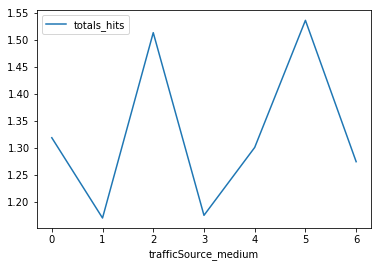

In [36]:
df_g = df_train.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

,trafficSource_medium,totals_hits
0,0,1.285853
1,1,1.278509
2,2,0.952445
3,3,1.168378
4,4,1.208938
5,5,1.413604
6,6,0.910871


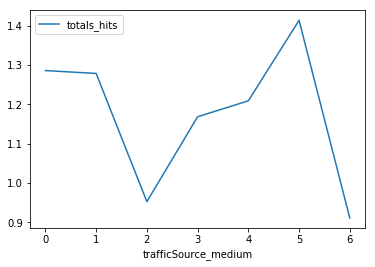

In [37]:
df_g = df_test.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

#### *_hits_per_day

In [38]:
# df_g = df_train.groupby(['day'])['totals_hits'].sum().reset_index()
# df_g.plot()
# df_g

In [39]:
# df_g = df_test.groupby(['day'])['totals_hits'].sum().reset_index()
# df_g.plot()
# df_g

#### Freq

In [40]:
# corr_cols = [c for c in df_train_X if '_Fre' in c]
# corr_cols

#### Compare corr between train and test

In [41]:
# corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols = df_test.columns
corr_dict, corr_train, corr_test = compare_corr(df_train[corr_cols], df_test[corr_cols])
pp.pprint(corr_dict)
pp.pprint(corr_train)
pp.pprint(corr_test)

{('browser_category', 'browser_category_Frequency'): 9.821131130938188e-05,
 ('browser_category', 'browser_operatingSystem'): 0.03314385333004666,
 ('browser_category', 'browser_operatingSystem_Frequency'): 0.01674483722500053,
 ('browser_category', 'browser_os'): 0.03314385333004666,
 ('browser_category', 'browser_os_Frequency'): 0.01674483722500053,
 ('browser_category', 'campaign_medium'): 0.20468858177415705,
 ('browser_category', 'campaign_medium_Frequency'): 0.13706084040377384,
 ('browser_category', 'channelGrouping_Frequency'): 0.11141389099530509,
 ('browser_category', 'device_browser_Frequency'): 0.02946192152425986,
 ('browser_category', 'device_deviceCategory_Frequency'): 0.10756388517568793,
 ('browser_category', 'device_isMobile_Frequency'): 0.1031304713737311,
 ('browser_category', 'device_operatingSystem_Frequency'): 0.040969968576676286,
 ('browser_category', 'geoNetwork_city_Frequency'): 0.0008993537723234052,
 ('browser_category', 'geoNetwork_continent_Frequency'): 0

 ('device_browser', 'geoNetwork_networkDomain'): 0.00042213159412026954,
 ('device_browser', 'geoNetwork_networkDomain_Frequency'): 0.056870899346034884,
 ('device_browser', 'geoNetwork_region'): 0.002873251943691235,
 ('device_browser', 'geoNetwork_region_Frequency'): 0.0216244431241618,
 ('device_browser', 'geoNetwork_subContinent'): 0.07399246803718472,
 ('device_browser', 'geoNetwork_subContinent_Frequency'): 0.0711124114534261,
 ('device_browser', 'hour'): 0.006838263699042391,
 ('device_browser', 'hour_unique_user_count'): 0.017770657491061367,
 ('device_browser', 'lda_totals_pageviews_0'): 0.07545346287112109,
 ('device_browser', 'lda_totals_pageviews_1'): 0.2203318549522764,
 ('device_browser', 'lda_totals_pageviews_2'): 0.12820908525914881,
 ('device_browser', 'lda_totals_pageviews_3'): 0.07934479109124358,
 ('device_browser', 'lda_totals_pageviews_4'): 0.021164988388963774,
 ('device_browser', 'max_hits_per_day'): 0.002192168220646465,
 ('device_browser', 'max_hits_per_hour')

 ('geoNetwork_continent', 'mean_k_fold_device_operatingSystem'): 0.04995757692394705,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_city'): 0.013797465844683665,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_continent'): 0.026429332213143364,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_country'): 0.020071688743474758,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_metro'): 0.01995361253853689,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_networkDomain'): 0.0512966001109208,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_region'): 0.011564697365484156,
 ('geoNetwork_continent', 'mean_k_fold_geoNetwork_subContinent'): 0.017730555748875387,
 ('geoNetwork_continent', 'mean_k_fold_source_country'): 0.009119734569116078,
 ('geoNetwork_continent', 'mean_k_fold_trafficSource_adContent'): 0.030466342895824554,
 ('geoNetwork_continent', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): 0.02802396771867545,
 ('geoNetwork_continent', 'mean_k_fold_trafficSource_a

 ('geoNetwork_subContinent', 'visitStartTime_b1_diff'): 0.054589283548681186,
 ('geoNetwork_subContinent', 'visitStartTime_b2_diff'): 0.04780770562082089,
 ('geoNetwork_subContinent', 'weekday'): 0.011205403437687413,
 ('geoNetwork_subContinent', 'weekday_unique_user_count'): 0.018442723465000557,
 ('geoNetwork_subContinent_Frequency', 'browser_category_Frequency'): 0.03441973050512678,
 ('geoNetwork_subContinent_Frequency', 'browser_operatingSystem_Frequency'): 0.003745970530697043,
 ('geoNetwork_subContinent_Frequency', 'browser_os_Frequency'): 0.003745970530697043,
 ('geoNetwork_subContinent_Frequency', 'campaign_medium_Frequency'): 0.004113004398406311,
 ('geoNetwork_subContinent_Frequency', 'lda_totals_pageviews_0'): 0.228757939088028,
 ('geoNetwork_subContinent_Frequency', 'lda_totals_pageviews_1'): 0.006882630244501614,
 ('geoNetwork_subContinent_Frequency', 'lda_totals_pageviews_2'): 0.09912514282537767,
 ('geoNetwork_subContinent_Frequency', 'lda_totals_pageviews_3'): 0.145876

 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_geoNetwork_subContinent'): 0.007666448061323217,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_source_country'): 0.01808350832304484,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_adContent'): 0.062376800750305314,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): 0.03213370869354448,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): 0.01095684000883844,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'): 0.026190849517703646,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_adwordsClickInfo.page'): 0.01384475248570824,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_adwordsClickInfo.slot'): 0.11967925780242059,
 ('mean_k_fold_geoNetwork_continent', 'mean_k_fold_trafficSource_campaign'): 0.013868134207489086,
 ('mean_k_fold_geoNetwork_continent', 'm

 ('month', 'trafficSource_adwordsClickInfo.gclId_Frequency'): 0.1402171272776811,
 ('month', 'trafficSource_adwordsClickInfo.isVideoAd_Frequency'): 0.1404011227706168,
 ('month', 'trafficSource_adwordsClickInfo.page_Frequency'): 0.14055693496582244,
 ('month', 'trafficSource_adwordsClickInfo.slot_Frequency'): 0.14030932832422008,
 ('month', 'trafficSource_campaign_Frequency'): 0.10635850487520979,
 ('month', 'trafficSource_isTrueDirect_Frequency'): 0.09645097490917212,
 ('month', 'trafficSource_keyword_Frequency'): 0.19251127350310787,
 ('month', 'trafficSource_medium_Frequency'): 0.05794173679284931,
 ('month', 'trafficSource_referralPath_Frequency'): 0.2950476009834553,
 ('month', 'trafficSource_source_Frequency'): 0.18145077874584764,
 ('month', 'user_hour_max'): 0.017852181446351367,
 ('month', 'user_hour_mean'): 0.0021925461855033454,
 ('month', 'user_hour_min'): 0.012824009300801551,
 ('month', 'var_hits_per_day'): 0.042909164206526365,
 ('month', 'visitStartTime_b1_diff'): 0.017

 ('trafficSource_adContent', 'medium_hits_max'): 0.7813214397231519,
 ('trafficSource_adContent', 'medium_hits_mean'): 1.1244831818386445,
 ('trafficSource_adContent', 'medium_hits_min'): 6.80258630315137e-14,
 ('trafficSource_adContent', 'medium_hits_sum'): 0.19859686501902757,
 ('trafficSource_adContent', 'month'): 0.11374892864743605,
 ('trafficSource_adContent', 'month_unique_user_count'): 0.11509086918689962,
 ('trafficSource_adContent', 'pca_totals_hits_0'): 0.2212147143926103,
 ('trafficSource_adContent', 'pca_totals_hits_1'): 0.003486903927051874,
 ('trafficSource_adContent', 'pca_totals_hits_2'): 0.03763490991684115,
 ('trafficSource_adContent', 'pca_totals_hits_3'): 0.09274006864031575,
 ('trafficSource_adContent', 'pca_totals_hits_4'): 0.04331820632445382,
 ('trafficSource_adContent', 'pca_totals_hits_5'): 0.0011836119887870065,
 ('trafficSource_adContent', 'pca_totals_hits_6'): 0.014640663132695294,
 ('trafficSource_adContent', 'pca_totals_hits_7'): 0.011837956771282711,
 (

 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_channelGrouping'): 0.04331528647227839,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_device_browser'): 0.029190200059736257,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_device_deviceCategory'): 0.07960932141008153,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_device_isMobile'): 0.07977989835351486,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_device_operatingSystem'): 0.040026908156093464,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_geoNetwork_city'): 0.04016088583085281,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_geoNetwork_continent'): 0.04289552268203514,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_geoNetwork_country'): 0.07175884905798177,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_geoNetwork_metro'): 0.04219185685093102,
 ('trafficSource_isTrueDirect_Frequency', 'mean_k_fold_geoNetwork_networkDomain'): 0.07357833401563262,
 ('trafficSource_i

 ('var_hits_per_day', 'pca_totals_hits_3'): 0.008821212880340604,
 ('var_hits_per_day', 'pca_totals_hits_4'): 0.0013113540934604276,
 ('var_hits_per_day', 'pca_totals_hits_5'): 0.046090821690692674,
 ('var_hits_per_day', 'pca_totals_hits_6'): 0.01859765013613198,
 ('var_hits_per_day', 'pca_totals_hits_7'): 0.00947191256615199,
 ('var_hits_per_day', 'pca_totals_hits_8'): 0.022624973611851482,
 ('var_hits_per_day', 'pca_totals_hits_9'): 0.012690702207268034,
 ('var_hits_per_day', 'source_country_Frequency'): 0.01010513308319912,
 ('var_hits_per_day', 'sum_hits_per_hour'): 7.663443356695915e-05,
 ('var_hits_per_day', 'sum_hits_per_network_domain'): 0.010166925946440569,
 ('var_hits_per_day', 'totals_hits_b1'): 3.208759082917734e-05,
 ('var_hits_per_day', 'totals_pageviews_b1'): 2.563660846386165e-05,
 ('var_hits_per_day', 'trafficSource_adContent_Frequency'): 0.028074331143402,
 ('var_hits_per_day', 'trafficSource_adwordsClickInfo.adNetworkType_Frequency'): 0.03261360637499715,
 ('var_hit

{('browser_category', 'browser_category_Frequency'): -0.8363953883356617,
 ('browser_category', 'browser_operatingSystem'): 0.43915597075107604,
 ('browser_category', 'browser_operatingSystem_Frequency'): -0.5992372127200993,
 ('browser_category', 'browser_os'): 0.43915597075107604,
 ('browser_category', 'browser_os_Frequency'): -0.5992372127200993,
 ('browser_category', 'campaign_medium'): 0.011148226752051555,
 ('browser_category', 'campaign_medium_Frequency'): 0.003357193056189037,
 ('browser_category', 'channelGrouping_Frequency'): 0.06333377795376362,
 ('browser_category', 'device_browser_Frequency'): -0.7769346787491771,
 ('browser_category', 'device_deviceCategory_Frequency'): -0.6248388584668969,
 ('browser_category', 'device_isMobile_Frequency'): -0.5920321271078399,
 ('browser_category', 'device_operatingSystem_Frequency'): -0.39073544862943055,
 ('browser_category', 'geoNetwork_city_Frequency'): 0.10192600290259948,
 ('browser_category', 'geoNetwork_continent_Frequency'): -0

 ('device_browser', 'trafficSource_isTrueDirect'): -0.11314655875982067,
 ('device_browser', 'trafficSource_isTrueDirect_Frequency'): 0.11314655875868894,
 ('device_browser', 'trafficSource_keyword'): 0.02313206504982652,
 ('device_browser', 'trafficSource_keyword_Frequency'): -0.020205039802483053,
 ('device_browser', 'trafficSource_medium'): -0.043489959166105284,
 ('device_browser', 'trafficSource_medium_Frequency'): 0.03559470553918573,
 ('device_browser', 'trafficSource_referralPath'): 0.06731243016976199,
 ('device_browser', 'trafficSource_referralPath_Frequency'): -0.06261153389320215,
 ('device_browser', 'trafficSource_source'): 0.1709061200801349,
 ('device_browser', 'trafficSource_source_Frequency'): -0.11242878553096161,
 ('device_browser', 'user_hour_max'): -0.08912433261970544,
 ('device_browser', 'user_hour_mean'): -0.0521578139465016,
 ('device_browser', 'user_hour_min'): 0.00447969492469225,
 ('device_browser', 'var_hits_per_day'): -0.013077925135560109,
 ('device_brows

 ('geoNetwork_continent_Frequency', 'mean_k_fold_browser_category'): 0.10538963098263159,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_browser_operatingSystem'): 0.26736331722712203,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_browser_os'): 0.26736331722712203,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_campaign_medium'): 0.05696906334757964,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_channelGrouping'): 0.2700225072365172,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_device_browser'): 0.12171879818341297,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_device_deviceCategory'): -0.026539396186938204,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_device_isMobile'): -0.02611133416100924,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_device_operatingSystem'): 0.1637928787538979,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_geoNetwork_city'): 0.46596958631739066,
 ('geoNetwork_continent_Frequency', 'mean_k_fold_geoNetwork_continent'): 0.9692071062060976,


 ('hour', 'mean_k_fold_browser_os'): 0.083592507362228,
 ('hour', 'mean_k_fold_campaign_medium'): 0.012595314587312133,
 ('hour', 'mean_k_fold_channelGrouping'): 0.07896208317081009,
 ('hour', 'mean_k_fold_device_browser'): 0.04528747849495824,
 ('hour', 'mean_k_fold_device_deviceCategory'): 0.02502886112746334,
 ('hour', 'mean_k_fold_device_isMobile'): 0.02502325901364908,
 ('hour', 'mean_k_fold_device_operatingSystem'): 0.050836500473114235,
 ('hour', 'mean_k_fold_geoNetwork_city'): 0.12830733475265152,
 ('hour', 'mean_k_fold_geoNetwork_continent'): 0.1038005864849489,
 ('hour', 'mean_k_fold_geoNetwork_country'): 0.09072049505030767,
 ('hour', 'mean_k_fold_geoNetwork_metro'): 0.12463328889436497,
 ('hour', 'mean_k_fold_geoNetwork_networkDomain'): 0.059749010023561276,
 ('hour', 'mean_k_fold_geoNetwork_region'): 0.12497608521186336,
 ('hour', 'mean_k_fold_geoNetwork_subContinent'): 0.09218680038503174,
 ('hour', 'mean_k_fold_source_country'): 0.08933212478712224,
 ('hour', 'mean_k_fol

 ('mean_k_fold_source_country', 'pca_totals_hits_8'): 0.15722845087128298,
 ('mean_k_fold_source_country', 'pca_totals_hits_9'): 0.26196194019136904,
 ('mean_k_fold_trafficSource_adContent', 'lda_totals_pageviews_0'): 0.05498869652615734,
 ('mean_k_fold_trafficSource_adContent', 'lda_totals_pageviews_1'): 0.029157929184581134,
 ('mean_k_fold_trafficSource_adContent', 'lda_totals_pageviews_2'): 0.030755398416061678,
 ('mean_k_fold_trafficSource_adContent', 'lda_totals_pageviews_3'): -0.058068380748117224,
 ('mean_k_fold_trafficSource_adContent', 'lda_totals_pageviews_4'): -0.17119998583220405,
 ('mean_k_fold_trafficSource_adContent', 'mean_k_fold_browser_category'): 0.00738535518919516,
 ('mean_k_fold_trafficSource_adContent', 'mean_k_fold_browser_operatingSystem'): 0.012628949675007103,
 ('mean_k_fold_trafficSource_adContent', 'mean_k_fold_browser_os'): 0.012628949675007103,
 ('mean_k_fold_trafficSource_adContent', 'mean_k_fold_campaign_medium'): 0.177881568506497,
 ('mean_k_fold_traff

 ('sum_hits_per_day', 'mean_k_fold_geoNetwork_country'): 0.006475626490561676,
 ('sum_hits_per_day', 'mean_k_fold_geoNetwork_metro'): 0.007853438124914116,
 ('sum_hits_per_day', 'mean_k_fold_geoNetwork_networkDomain'): 0.006758789654052258,
 ('sum_hits_per_day', 'mean_k_fold_geoNetwork_region'): 0.007533351656335879,
 ('sum_hits_per_day', 'mean_k_fold_geoNetwork_subContinent'): 0.005840355613924356,
 ('sum_hits_per_day', 'mean_k_fold_source_country'): 0.007197427047103814,
 ('sum_hits_per_day', 'mean_k_fold_trafficSource_adContent'): 0.003758740350500771,
 ('sum_hits_per_day', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): 0.000743526598872133,
 ('sum_hits_per_day', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): -0.0021338993619924476,
 ('sum_hits_per_day', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'): 0.0007324949201421819,
 ('sum_hits_per_day', 'mean_k_fold_trafficSource_adwordsClickInfo.page'): 0.0007683813627079532,
 ('sum_hits_per_day', 'mean_k_fold_

 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_source_country'): 0.1745037594582093,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_adContent'): 0.2931320429210043,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): 0.8398148147488197,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): 0.049945693490693596,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'): 0.8402388457953461,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_adwordsClickInfo.page'): 0.8300795010814473,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_adwordsClickInfo.slot'): 0.8198360608470879,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_campaign'): 0.5096031843767327,
 ('trafficSource_adwordsClickInfo.gclId', 'mean_k_fold_trafficSource_isTrueDirect'): -0.05314088235286023,
 ('traffic

 ('trafficSource_medium', 'pca_totals_hits_3'): -0.046042160088507325,
 ('trafficSource_medium', 'pca_totals_hits_4'): 0.2028959545852413,
 ('trafficSource_medium', 'pca_totals_hits_5'): 0.05175222189947845,
 ('trafficSource_medium', 'pca_totals_hits_6'): -0.0004886802034374395,
 ('trafficSource_medium', 'pca_totals_hits_7'): 0.010085634125665153,
 ('trafficSource_medium', 'pca_totals_hits_8'): 0.07900353223109041,
 ('trafficSource_medium', 'pca_totals_hits_9'): 0.073647251187761,
 ('trafficSource_medium', 'source_country'): 0.1971146251893141,
 ('trafficSource_medium', 'source_country_Frequency'): -0.2050224801117966,
 ('trafficSource_medium', 'sum_hits_per_day'): 0.007858935307463278,
 ('trafficSource_medium', 'sum_hits_per_hour'): 0.029339175572089187,
 ('trafficSource_medium', 'sum_hits_per_network_domain'): 0.05655231080447947,
 ('trafficSource_medium', 'totals_hits_b1'): 0.04401818190710657,
 ('trafficSource_medium', 'totals_pageviews_b1'): 0.045087556555904296,
 ('trafficSource_

 ('visitStartTime_b1_diff', 'mean_k_fold_geoNetwork_country'): 0.2063205698749262,
 ('visitStartTime_b1_diff', 'mean_k_fold_geoNetwork_metro'): 0.18111403976624352,
 ('visitStartTime_b1_diff', 'mean_k_fold_geoNetwork_networkDomain'): 0.1891244753452521,
 ('visitStartTime_b1_diff', 'mean_k_fold_geoNetwork_region'): 0.1798137246924168,
 ('visitStartTime_b1_diff', 'mean_k_fold_geoNetwork_subContinent'): 0.20770116814148962,
 ('visitStartTime_b1_diff', 'mean_k_fold_source_country'): 0.22493834053234874,
 ('visitStartTime_b1_diff', 'mean_k_fold_trafficSource_adContent'): -0.03295734994706969,
 ('visitStartTime_b1_diff', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): 0.03343498064804934,
 ('visitStartTime_b1_diff', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): 0.018049503983715482,
 ('visitStartTime_b1_diff', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'): 0.03343456597414842,
 ('visitStartTime_b1_diff', 'mean_k_fold_trafficSource_adwordsClickInfo.page'): 0.0334

 ('browser_os', 'mean_k_fold_trafficSource_campaign'): 0.03816476185132503,
 ('browser_os', 'mean_k_fold_trafficSource_isTrueDirect'): 0.05408305897609379,
 ('browser_os', 'mean_k_fold_trafficSource_keyword'): 0.04289663587215404,
 ('browser_os', 'mean_k_fold_trafficSource_medium'): 0.15643443266497475,
 ('browser_os', 'mean_k_fold_trafficSource_referralPath'): 0.16260417447361333,
 ('browser_os', 'mean_k_fold_trafficSource_source'): -0.017259902100651463,
 ('browser_os', 'mean_pageviews_per_network_domain'): 0.0770988283007664,
 ('browser_os', 'medium_hits_max'): -0.012739639777975448,
 ('browser_os', 'medium_hits_mean'): -0.06238812486413937,
 ('browser_os', 'medium_hits_min'): 2.3313922056942626e-14,
 ('browser_os', 'medium_hits_sum'): -0.10403280805200137,
 ('browser_os', 'pca_totals_hits_0'): 0.05794017444057267,
 ('browser_os', 'pca_totals_hits_1'): -0.08340485028949667,
 ('browser_os', 'pca_totals_hits_2'): 0.041273397612582426,
 ('browser_os', 'pca_totals_hits_3'): 0.0700523068

 ('device_isMobile', 'mean_k_fold_geoNetwork_continent'): 0.008793790789896252,
 ('device_isMobile', 'mean_k_fold_geoNetwork_country'): 0.010389476712791232,
 ('device_isMobile', 'mean_k_fold_geoNetwork_metro'): -0.06516396437895243,
 ('device_isMobile', 'mean_k_fold_geoNetwork_networkDomain'): 0.019349420725411938,
 ('device_isMobile', 'mean_k_fold_geoNetwork_region'): -0.05697160646370646,
 ('device_isMobile', 'mean_k_fold_geoNetwork_subContinent'): 0.00714206471238733,
 ('device_isMobile', 'mean_k_fold_source_country'): 0.015693660628405406,
 ('device_isMobile', 'mean_k_fold_trafficSource_adContent'): 0.18882970933781792,
 ('device_isMobile', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): 0.03412381114771559,
 ('device_isMobile', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): -0.0019068044393270765,
 ('device_isMobile', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'): 0.2558104146418088,
 ('device_isMobile', 'mean_k_fold_trafficSource_adwordsClickInfo.pag

 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_adwordsClickInfo.page'): 0.05715339173005212,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_adwordsClickInfo.slot'): -0.015964108720750193,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_campaign'): 0.05669235849960496,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_isTrueDirect'): 0.06468950165311482,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_keyword'): 0.017276170594061856,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_medium'): 0.12160156951145983,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_referralPath'): 0.2417405864314886,
 ('geoNetwork_networkDomain_Frequency', 'mean_k_fold_trafficSource_source'): 0.09674469246726368,
 ('geoNetwork_networkDomain_Frequency', 'pca_totals_hits_0'): 0.059736385752596974,
 ('geoNetwork_networkDomain_Frequency', 'pca_totals_hits_1'): -0.2785278283523022,
 (

 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_geoNetwork_networkDomain'): 0.2058917375278103,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_geoNetwork_region'): 0.24637851664362959,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_geoNetwork_subContinent'): 0.23050498571130584,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_source_country'): 0.24361536922074012,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_trafficSource_adContent'): -0.10663916259666914,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): -0.005840964787807296,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): 0.004172735246330801,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'): -0.14620553438945194,
 ('mean_k_fold_device_operatingSystem', 'mean_k_fold_trafficSource_adwordsClickInfo.page'): -0.13668129718376096,
 ('mean_k_fold_device_operatingSystem

 ('source_country', 'device_operatingSystem_Frequency'): 0.036464862421194864,
 ('source_country', 'geoNetwork_city_Frequency'): 0.07781487486696469,
 ('source_country', 'geoNetwork_continent_Frequency'): -0.24034382763889225,
 ('source_country', 'geoNetwork_country_Frequency'): -0.25973536156565763,
 ('source_country', 'geoNetwork_metro_Frequency'): 0.11372186500954057,
 ('source_country', 'geoNetwork_networkDomain_Frequency'): -0.07755340882506935,
 ('source_country', 'geoNetwork_region_Frequency'): 0.06577845669392066,
 ('source_country', 'geoNetwork_subContinent_Frequency'): -0.2753393295613331,
 ('source_country', 'lda_totals_pageviews_0'): -0.2496186501963148,
 ('source_country', 'lda_totals_pageviews_1'): -0.13598071240148393,
 ('source_country', 'lda_totals_pageviews_2'): 0.08339667926178637,
 ('source_country', 'lda_totals_pageviews_3'): 0.35228532150356606,
 ('source_country', 'lda_totals_pageviews_4'): 0.06362260727376351,
 ('source_country', 'max_hits_per_day'): 0.001194578

 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_geoNetwork_metro'): -0.061654381686571315,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_geoNetwork_networkDomain'): -0.10584819895444884,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_geoNetwork_region'): -0.07592699637786396,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_geoNetwork_subContinent'): -0.1636416027020267,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_source_country'): -0.22050444680389583,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_trafficSource_adContent'): -0.6363702028128325,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_trafficSource_adwordsClickInfo.adNetworkType'): -0.997751993270099,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_trafficSource_adwordsClickInfo.gclId'): -0.11009215531891084,
 ('trafficSource_adwordsClickInfo.gclId_Frequency', 'mean_k_fold_trafficSource

 ('trafficSource_referralPath', 'medium_hits_min'): 4.8705323434002257e-14,
 ('trafficSource_referralPath', 'medium_hits_sum'): -0.05159895694576917,
 ('trafficSource_referralPath', 'month'): -0.14585168313867247,
 ('trafficSource_referralPath', 'month_unique_user_count'): -0.05828009451840242,
 ('trafficSource_referralPath', 'pca_totals_hits_0'): -0.08611736434122329,
 ('trafficSource_referralPath', 'pca_totals_hits_1'): -0.005733601962007421,
 ('trafficSource_referralPath', 'pca_totals_hits_2'): 0.9981950521014009,
 ('trafficSource_referralPath', 'pca_totals_hits_3'): 0.013699868599436341,
 ('trafficSource_referralPath', 'pca_totals_hits_4'): -0.06925416493983368,
 ('trafficSource_referralPath', 'pca_totals_hits_5'): -0.02038733282794644,
 ('trafficSource_referralPath', 'pca_totals_hits_6'): -0.004592288727032743,
 ('trafficSource_referralPath', 'pca_totals_hits_7'): -0.012059204581122099,
 ('trafficSource_referralPath', 'pca_totals_hits_8'): -0.010915934189564602,
 ('trafficSource_r

In [42]:
dict_to_sortedlist(corr_dict)

["0 (('medium_hits_mean', 'trafficSource_keyword_Frequency'), 1.4598244087226102)",
 "1 (('trafficSource_adwordsClickInfo.adNetworkType', 'mean_k_fold_trafficSource_adwordsClickInfo.slot'), 1.3385013694352934)",
 "2 (('medium_hits_mean', 'trafficSource_adwordsClickInfo.gclId_Frequency'), 1.3222531639835726)",
 "3 (('medium_hits_mean', 'trafficSource_adwordsClickInfo.isVideoAd_Frequency'), 1.3207382502777565)",
 "4 (('trafficSource_adwordsClickInfo.isVideoAd', 'medium_hits_mean'), 1.3207382502589915)",
 "5 (('medium_hits_mean', 'trafficSource_adwordsClickInfo.adNetworkType_Frequency'), 1.320735617132235)",
 "6 (('medium_hits_mean', 'trafficSource_adwordsClickInfo.slot_Frequency'), 1.3207343525645083)",
 "7 (('medium_hits_mean', 'trafficSource_adwordsClickInfo.page_Frequency'), 1.3207126914744611)",
 "8 (('medium_hits_mean', 'mean_k_fold_trafficSource_adwordsClickInfo.isVideoAd'), 1.3183161669597196)",
 "9 (('trafficSource_adwordsClickInfo.slot', 'medium_hits_mean'), 1.2921076806007536)"